In [101]:
import os
import math
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [70]:
def read_data(index, n_gram):
    pref = "messages/part"
    directory = pref + str(index) + "/"
    words_freq = [[] for i in range(2)]
    files = os.listdir(directory)
    for file in files:
        type = 0
        if "legit" in file:
            type = 1
        filename = directory + file
        f = open(filename, "r")
        n_grams = set()
        for i, line in enumerate(f.readlines()):
            arr = line.split()
            if i == 0:
                arr = arr[1:]
            a = list(map(int, arr))
            for j in range(len(a) - n_gram + 1):
                n_grams.add(tuple(a[j:j + n_gram]))
        words_freq[type].append(n_grams)
    return words_freq

In [106]:
def calc_p(alpha, cnt, total):
    return (cnt + alpha) / (total + alpha * 2)


def norm(scores, errors):
    mx = max(scores)
    ans = []
    for i in range(len(scores)):
        if scores[i]:
            ans.append(math.exp(scores[i] - mx) * errors[i])
        else:
            ans.append(0)
    return ans

def bayes(errors, alpha, train_words, test_words, f):
    N = len(train_words)
    K = 2
    cnt_types = [0 for i in range(K)]
    words_freq = [dict() for i in range(K)]
    words = set()
    for i in range(K):
        type = i
        cnt_types[i] += len(train_words[i])
        for j in range(len(train_words[i])):
            for x in train_words[i][j]:
                if words_freq[i].get(x) is None:
                    words_freq[i][x] = 0
                words_freq[i][x] += 1
                words.add(x)

    for i in range(K):
        for x in words:
            if words_freq[i].get(x) is None:
                words_freq[i][x] = 0

    words_probability = [dict() for i in range(K)]
    for i in range(K):
        t = words_freq[i].items()
        for x in t:
            words_probability[i][x[0]] = calc_p(alpha, x[1], cnt_types[i])

    M = len(test_words)
    ans = []
    for i in range(M):
        cur_words = test_words[i]
        scores = []
        for j in range(K):
            t = words_probability[j].items()
            res = 0
            for x in t:
                if x[0] in cur_words:
                    res += math.log(x[1])
                else:
                    res += math.log(1 - x[1])
            if cnt_types[j] == 0:
                scores.append(0)
            else:
                res += math.log(cnt_types[j] / N)
                scores.append(res)
        scores = norm(scores, errors)
        s = sum(scores)
        for i in range(len(scores)):
            scores[i] /= s
        if f:
            if scores[0] > scores[1]:
                ans.append(0)
            else:
                ans.append(1)
        else:
            ans.append(scores[1])
    return ans

In [107]:
def get_train_test(w, ind):
    w_train = [[], []]
    w_test = [[], []]
    for i in range(len(w)):
        if i == ind:
            for k in range(2):
                for j in range(len(w[i][k])):
                    w_test[k].append(w[i][k][j])
        else:
            for k in range(2):
                 for j in range(len(w[i][k])):
                    w_train[k].append(w[i][k][j])
    return w_train, w_test

def calc_score(errors, alpha, w):
    sum = 0
    for i in range(10):
        w_train, w_test = get_train_test(w, i)
        ans_real = []
        test_real = []
        for j in range(len(w_test)):
            for t in range(len(w_test[j])):
                test_real.append(w_test[j][t])
                ans_real.append(j)
        ans_pred = bayes(errors, alpha, w_train, test_real, 1)
        sum += accuracy_score(ans_pred, ans_real)
    return sum / 10

def calc_y(errors, alpha, w):
    sum = 0
    total_ans_pred = []
    total_ans_real = []
    for i in range(10):
        w_train, w_test = get_train_test(w, i)
        ans_real = []
        test_real = []
        for j in range(len(w_test)):
            for t in range(len(w_test[j])):
                test_real.append(w_test[j][t])
                ans_real.append(j)
                total_ans_real.append(j)
        ans_pred = bayes(errors, alpha, w_train, test_real, 0)
        for j in ans_pred:
            total_ans_pred.append(j)
        
    return total_ans_pred, total_ans_real 

In [78]:
def get_best_params():
    best_score = 0
    best = (-1, -1, -1)
    for n_gram in tqdm([1, 2, 3]):
        w = []
        for i in range(1, 11):
            w.append(read_data(i, n_gram))
            #print(len(w[i - 1][0]), len(w[i - 1][1]))
        for alpha in tqdm([1, 1e-4, 1e-6, 1e-9], leave = False):
            for lambda2 in tqdm([0, 1, 2, 3, 5], leave = False):
                if (n_gram >= 2 and lambda2 != 1):
                    continue
                
                lamdas = [1, 10 ** lambda2]
                score = calc_score(lamdas, alpha, w)
                print(lamdas, alpha, score)
                if score > best_score:
                    score = best_score
                    best = (n_gram, lamdas, alpha)
    print(score, best)
get_best_params()


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:25<01:42, 25.51s/it]

[1, 1] 1 0.9155963302752295




 40%|████      | 2/5 [00:51<01:16, 25.54s/it]

[1, 10] 1 0.9119266055045874




 60%|██████    | 3/5 [01:16<00:51, 25.55s/it]

[1, 100] 1 0.9045871559633027




 80%|████████  | 4/5 [01:42<00:25, 25.57s/it]

[1, 1000] 1 0.8954128440366974




100%|██████████| 5/5 [02:08<00:00, 25.64s/it]

                                             
 25%|██▌       | 1/4 [02:08<06:24, 128.13s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

[1, 100000] 1 0.8834862385321101




 20%|██        | 1/5 [00:26<01:44, 26.18s/it]

[1, 1] 0.0001 0.9660550458715598




 40%|████      | 2/5 [00:51<01:18, 26.01s/it]

[1, 10] 0.0001 0.9642201834862385




 60%|██████    | 3/5 [01:17<00:51, 25.87s/it]

[1, 100] 0.0001 0.9596330275229359




 80%|████████  | 4/5 [01:43<00:25, 25.82s/it]

[1, 1000] 0.0001 0.9577981651376148




100%|██████████| 5/5 [02:08<00:00, 25.73s/it]

                                             
 50%|█████     | 2/4 [04:16<04:16, 128.26s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

[1, 100000] 0.0001 0.9559633027522937




 20%|██        | 1/5 [00:25<01:42, 25.72s/it]

[1, 1] 1e-06 0.9678899082568808




 40%|████      | 2/5 [00:51<01:17, 25.72s/it]

[1, 10] 1e-06 0.9669724770642203




 60%|██████    | 3/5 [01:17<00:51, 25.84s/it]

[1, 100] 1e-06 0.9660550458715598




 80%|████████  | 4/5 [01:44<00:26, 26.05s/it]

[1, 1000] 1e-06 0.9642201834862387




100%|██████████| 5/5 [02:10<00:00, 26.30s/it]

                                             
 75%|███████▌  | 3/4 [06:27<02:09, 129.08s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

[1, 100000] 1e-06 0.9596330275229359




 20%|██        | 1/5 [00:25<01:42, 25.68s/it]

[1, 1] 1e-09 0.9706422018348624




 40%|████      | 2/5 [00:51<01:17, 25.84s/it]

[1, 10] 1e-09 0.9706422018348624




 60%|██████    | 3/5 [01:17<00:51, 25.80s/it]

[1, 100] 1e-09 0.9697247706422021




 80%|████████  | 4/5 [01:43<00:25, 25.93s/it]

[1, 1000] 1e-09 0.967889908256881




100%|██████████| 5/5 [02:09<00:00, 25.87s/it]

                                             
 33%|███▎      | 1/3 [08:37<17:15, 517.84s/it]

[1, 100000] 1e-09 0.9660550458715598



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [03:22<05:03, 101.00s/it]

                                              
 25%|██▌       | 1/4 [03:22<10:06, 202.01s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

[1, 10] 1 0.7788990825688074




 40%|████      | 2/5 [03:35<05:22, 107.58s/it]

                                              
 50%|█████     | 2/4 [06:57<06:51, 205.96s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

[1, 10] 0.0001 0.9550458715596329




 40%|████      | 2/5 [03:37<05:25, 108.60s/it]

                                              
 75%|███████▌  | 3/4 [10:34<03:29, 209.33s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

[1, 10] 1e-06 0.9688073394495413




 40%|████      | 2/5 [03:35<05:23, 107.77s/it]

                                              
 67%|██████▋   | 2/3 [22:48<10:17, 617.74s/it]

[1, 10] 1e-09 0.9761467889908257



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [06:20<09:30, 190.21s/it]

                                              
 25%|██▌       | 1/4 [06:20<19:01, 380.43s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

[1, 10] 1 0.6972477064220183




 40%|████      | 2/5 [06:32<09:48, 196.18s/it]

                                              
 50%|█████     | 2/4 [12:52<12:48, 384.01s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

[1, 10] 0.0001 0.9229357798165138




 40%|████      | 2/5 [06:30<09:45, 195.19s/it]

                                              
 75%|███████▌  | 3/4 [19:23<06:25, 385.92s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

[1, 10] 1e-06 0.9412844036697245




 40%|████      | 2/5 [06:19<09:29, 189.75s/it]

                                              
100%|██████████| 3/3 [48:32<00:00, 970.84s/it]

[1, 10] 1e-09 0.9596330275229358
0 (3, [1, 10], 1e-09)


In [82]:
def check_spam(errors, alpha, w):
    sum = 0
    for i in range(10):
        if (i == 8):
            continue
        w_train, w_test = get_train_test(w, i)
        test_real = []
        ans_real = []
        for j in range(len(w_test)):
            for t in range(len(w_test[j])):
                test_real.append(w_test[j][t])
                ans_real.append(j)
        ans_pred = bayes(errors, alpha, w_train, test_real)
        for j in range(len(ans_pred)):
            if ans_real[j] == 1 and ans_pred[j] == 0:
                print(i)
                return False
                
    return True

In [87]:
def get_lambda():
    w = []
    for i in range(1, 11):
        w.append(read_data(i, 2))
    alpha = 1e-9
    for power in range(180, 1, -1):
        print(power)
        if (check_spam([1, 10 ** power], alpha, w)):
            print(power)
            return power
        print("WE LOSE\n")
    

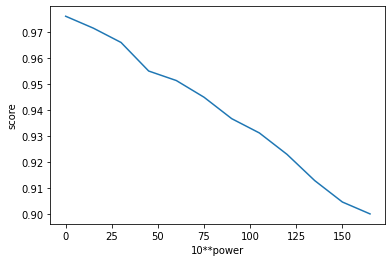

In [105]:
def drow_lambdas():
    pwr = 180
    alpha = 1e-9
    w = []
    for i in range(1, 11):
        w.append(read_data(i, 2))
    pwrs = []
    scores = []
    for power in range(0, 180, 15):
        lamdas = [1, 10 ** power]
        score = calc_score(lamdas, alpha, w)
        pwrs.append(power)
        scores.append(score)
    plt.plot(pwrs, scores)
    plt.xlabel("10**power")
    plt.ylabel("score")
    plt.show()
drow_lambdas()

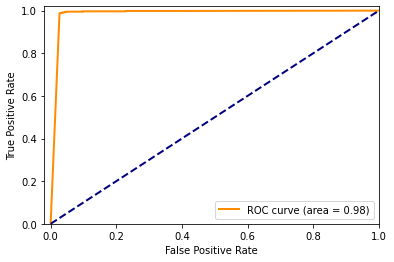

In [109]:
def drow_rcov():
    alpha = 1e-9
    w = []
    for i in range(1, 11):
        w.append(read_data(i, 2))
    lambdas = [1, 10]
    y_pred, y_true = calc_y(lambdas, alpha, w)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1])
    plt.ylim([0, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
drow_rcov()
    

In [ ]:
###